Analyzing CO2 data in Mauna Loa in Hawaii

 Atmospheric CO2 concentrations (ppm) derived from in situ air measurements                
 at Mauna Loa, Observatory, Hawaii: Latitude 19.5Â°N Longitude 155.6Â°W Elevation 3397m      
 Since December 2022 sampling has temporarily been relocated to MaunuaKea, Hawaii          
 Latitude 19.8Â°N Longitude 155.5Â°W Elevation 4145m      
                                                                                           
 Source: R. F. Keeling, S. J. Walker, S. C. Piper and A. F. Bollenbacher                   
 Scripps CO2 Program ( http://scrippsco2.ucsd.edu )                                        
 Scripps Institution of Oceanography (SIO)                                                 
 University of California                                                                  
 La Jolla, California USA 92093-0244                                                       
                                                                                           
 Status of data and correspondence:                                                        
                                                                                           
 These data are subject to revision based on recalibration of standard gases. Questions    
 about the data should be directed to Dr. Ralph Keeling (rkeeling@ucsd.edu), Stephen Walker
 (sjwalker@ucsd.edu) and Stephen Piper (scpiper@ucsd.edu), Scripps CO2 Program.            
                                                                                           
 Baseline data in this file through 03-Apr-2024 from archive dated 05-Apr-2024 13:23:37    


 The data file contains 10 columns.  Columns 1-4 give the dates in several redundant 
 formats. Column 5 below gives monthly Mauna Loa CO2 concentrations in micro-mol CO2 per   
 mole (ppm), reported on the 2012 SIO manometric mole fraction scale.  This is the        
 standard version of the data most often sought.  The monthly values have been adjusted    
 to 24:00 hours on the 15th of each month.  Column 6 gives the same data after a seasonal  
 adjustment to remove the quasi-regular seasonal cycle.  The adjustment involves           
 subtracting from the data a 4-harmonic fit with a linear gain factor.  Column 7 is a      
 smoothed version of the data generated from a stiff cubic spline function plus 4-harmonic 
 functions with linear gain.  Column 8 is the same smoothed version with the seasonal      
 cycle removed.  Column 9 is identical to Column 5 except that the missing values from     
 Column 5 have been filled with values from Column 7.  Column 10 is identical to Column 6  
 except missing values have been filled with values from Column 8.  Missing values are     
 denoted by -99.99                                                                         
                                                 
 Column 11 is the 3-digit sampling station identifier.  MLO refers to the Mauna Loa Observatory.
 MKO refers the summit of nearby Maunakea. MKO data are used to a fill a gap created by the 2022
 eruption of Mauna Loa, which led to the shutdown measurements by the Scripps CO2 program at MLO
 from Dec 2022 through Feb 2023
                                                                                           
 CO2 concentrations are measured on the '12' calibration scale                             


In [399]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima  

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error,mean_absolute_error

In [368]:
# The csv file contains information about the data in a header, we can remove the header while loading the data
#We are only interested in the raw data and can remove the additional data and fit columns
df = pd.read_csv('Data/monthly_in_situ_co2_mlo.csv',skiprows=61,parse_dates=True,usecols=[0,1,4])

df.head()

,Yr,Mn,CO2
0,,,
1,,,[ppm]
2,1958,01,-99.99
3,1958,02,-99.99
4,1958,03,315.71


In [369]:
#Removing empty rows
df  =df.drop(axis=0,index=[0,1])
df.head()

,Yr,Mn,CO2
2,1958,01,-99.99
3,1958,02,-99.99
4,1958,03,315.71
5,1958,04,317.45
6,1958,05,317.51


In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 2 to 805
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0     Yr      804 non-null    object
 1    Mn       804 non-null    object
 2        CO2  804 non-null    object
dtypes: object(3)
memory usage: 19.0+ KB


In [371]:
#The column names have extra spaces, we can strip it out
df.columns = [j.strip(' ') for j in df.columns]
df.columns

Index(['Yr', 'Mn', 'CO2'], dtype='object')

In [372]:
#We need to convert the CO2 column to be numeric
df['CO2'] = df['CO2'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 2 to 805
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Yr      804 non-null    object 
 1   Mn      804 non-null    object 
 2   CO2     804 non-null    float64
dtypes: float64(1), object(2)
memory usage: 19.0+ KB


In [373]:
#We need to combine the year and month to a data time index
df['date']=pd.to_datetime(dict(year=df['Yr'], month=df['Mn'], day=1))

# Set "date" to be the index
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,Yr,Mn,CO2
date,,,
1958-01-01,1958,01,-99.99
1958-02-01,1958,02,-99.99
1958-03-01,1958,03,315.71
1958-04-01,1958,04,317.45
1958-05-01,1958,05,317.51


<AxesSubplot:xlabel='date', ylabel='CO2'>

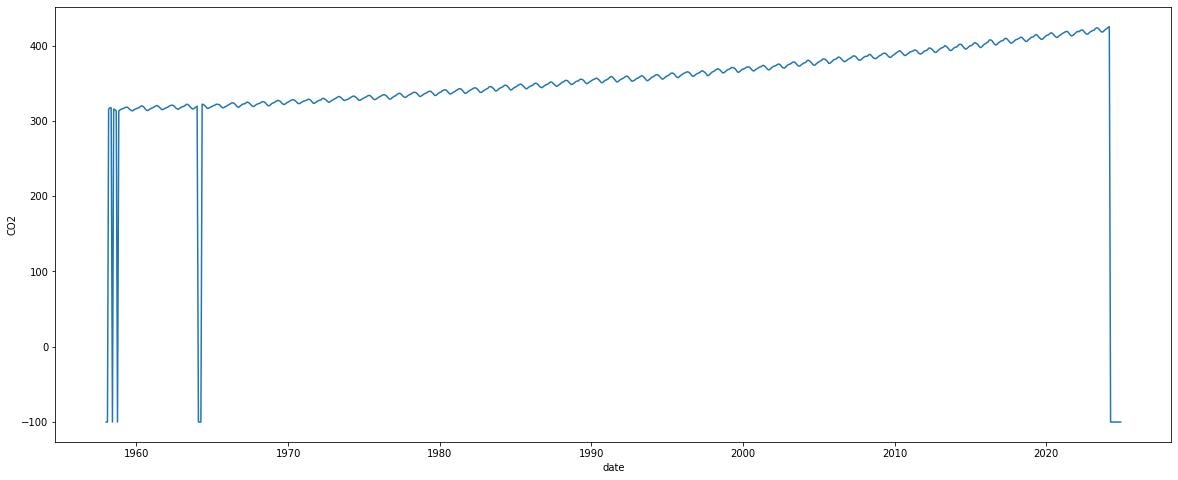

In [374]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='date',y='CO2')

In [375]:
#We can see that there are some missing values, that need to be cleaned up. 
#From the dataset documentation, missing data is represented by -99.99
#Let's see how many values are missing

print('missing data percentage is \n',df[df['CO2']==-99.99].count()/len(df) * 100)
print(df[df['CO2']==-99.99])

missing data percentage is 
 Yr     1.99005
Mn     1.99005
CO2    1.99005
dtype: float64
              Yr   Mn    CO2
date                        
1958-01-01  1958   01 -99.99
1958-02-01  1958   02 -99.99
1958-06-01  1958   06 -99.99
1958-10-01  1958   10 -99.99
1964-02-01  1964   02 -99.99
1964-03-01  1964   03 -99.99
1964-04-01  1964   04 -99.99
2024-04-01  2024   04 -99.99
2024-05-01  2024   05 -99.99
2024-06-01  2024   06 -99.99
2024-07-01  2024   07 -99.99
2024-08-01  2024   08 -99.99
2024-09-01  2024   09 -99.99
2024-10-01  2024   10 -99.99
2024-11-01  2024   11 -99.99
2024-12-01  2024   12 -99.99


In [376]:
#Only about two percent of the data is missing 
#Some are in the beginning of the data and some are for future dates, 
#We can delete the future dates and backfill the rest.

df = df[:-9]
df.tail()

,Yr,Mn,CO2
date,,,
2023-11-01,2023,11,420.12
2023-12-01,2023,12,421.65
2024-01-01,2024,01,422.62
2024-02-01,2024,02,424.35
2024-03-01,2024,03,425.22


In [377]:
#replace -99.99 with nan to make it easier to backfill
df['CO2'] = df['CO2'].replace(-99.99,np.nan)
df['CO2'] = df['CO2'].ffill().bfill()
df['CO2'].isnull().sum()

0

<AxesSubplot:xlabel='date', ylabel='CO2'>

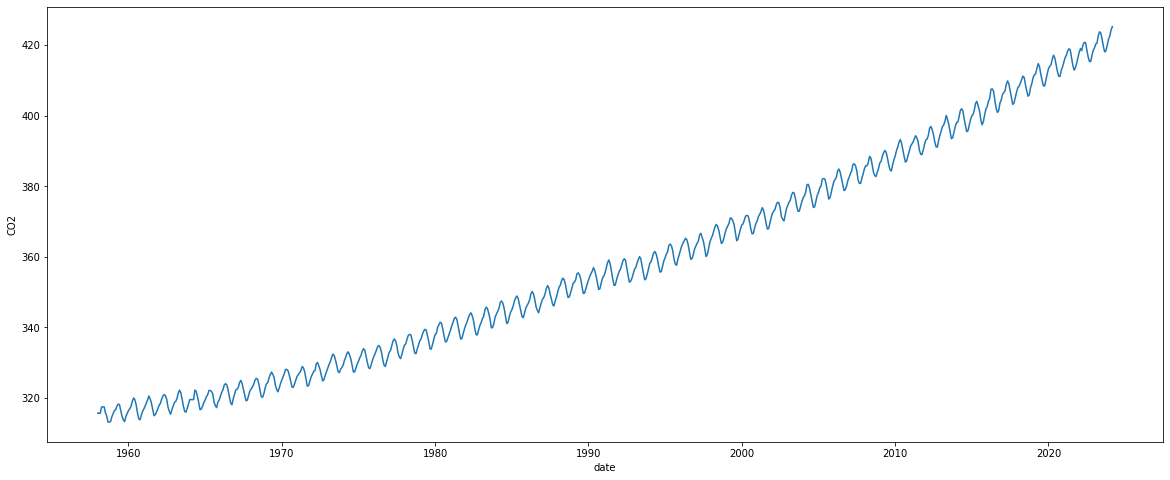

In [378]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='date',y='CO2')

In [379]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 795 entries, 1958-01-01 to 2024-03-01
Freq: MS
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Yr      795 non-null    object 
 1   Mn      795 non-null    object 
 2   CO2     795 non-null    float64
dtypes: float64(1), object(2)
memory usage: 24.8+ KB


Starting with the basics, we'll run an ETS decomposition to see the general behaviour

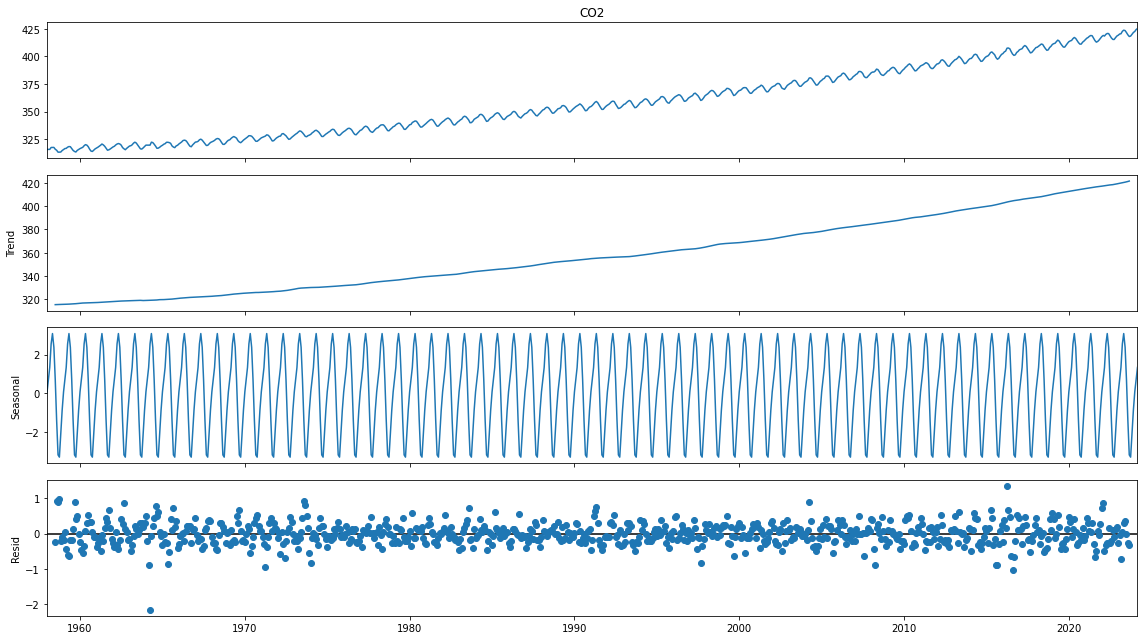

In [382]:
result = seasonal_decompose(df['CO2'], model='add')

fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

### SARIMA Model
We'll use SARIMA to model the data. To get the orders for SARIMA, we'll use the pmdarima.auto_arima method

In [383]:
auto_arima(df['CO2'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  795
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -259.448
Date:                              Mon, 15 Apr 2024   AIC                            530.896
Time:                                      19:13:58   BIC                            558.958
Sample:                                  01-01-1958   HQIC                           541.680
                                       - 03-01-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3412      0.030    -11.530      0.000      -0.399      -0.283
ma.L2         -0.0727      0.034     -2.161      0.031      -0.139      -0.007
ma.L3         -0.0911      0.021     -4.301      0.000      -0.133      -0.050
ar.S.L12       0.9995      0.000   2775.700      0.000       0.999       1.000
ma.S.L12      -0.8576      0.020    -42.056      0.000      -0.898      -0.818
sigma2         0.1052      0.004     24.399      0.000       0.097       0.114
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                28.17
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.00
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [384]:
#Now we'll split the data into train and test datasets. We'll use 2 years of data for testing
train = df.iloc[:-24]
test = df.iloc[len(df)-24:]

In [386]:
model = SARIMAX(train['CO2'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  CO2   No. Observations:                  771
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -250.741
Date:                              Mon, 15 Apr 2024   AIC                            513.482
Time:                                      19:14:43   BIC                            541.360
Sample:                                  01-01-1958   HQIC                           524.211
                                       - 03-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3555      0.029    -12.240      0.000      -0.412      -0.299
ma.L2         -0.0762      0.033     -2.299      0.021      -0.141      -0.011
ma.L3         -0.0854      0.033     -2.572      0.010      -0.151      -0.020
ar.S.L12       0.9995      0.000   2640.557      0.000       0.999       1.000
ma.S.L12      -0.8544      0.022    -39.540      0.000      -0.897      -0.812
sigma2         0.1048      0.005     23.156      0.000       0.096       0.114
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                29.41
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.02
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [387]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')\
    .rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

c:\Users\lokes\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


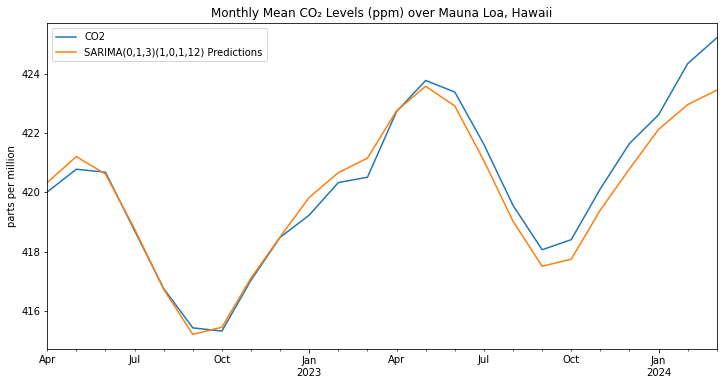

In [391]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['CO2'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [417]:
#Let's look at the prediction errors

rmse_error = np.sqrt(mean_squared_error(test['CO2'], predictions))
mae_error = mean_absolute_error(test['CO2'],predictions)
mean = np.mean(test['CO2'])

print(f'SARIMA(0,1,3)(1,0,1,12)\nRMSE Error: {rmse_error:11.10}')
print(f'MAE Error: {mae_error:11.10}')
print(f'Mean of the test data is: {mean:11.10}')

SARIMA(0,1,3)(1,0,1,12)
RMSE Error: 0.6256220044
MAE Error: 0.4636683398
Mean of the test data is:    420.1975


The errors are pretty good, we'll retrain the model on the full dataset and generate forecasts

In [415]:
model = SARIMAX(df['CO2'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df)-1,len(df)+11).rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

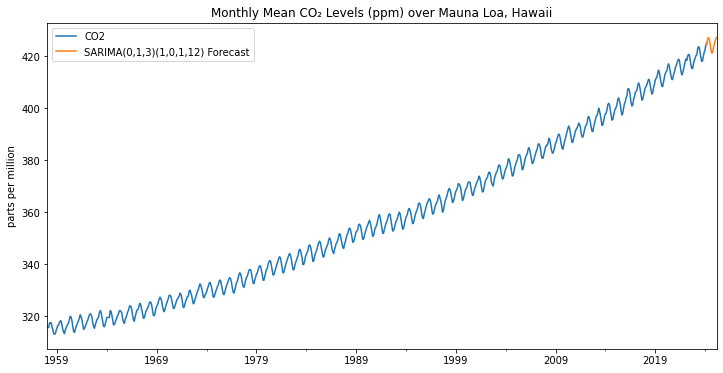

In [419]:
#Plotting the final results
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['CO2'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);